<a href="https://colab.research.google.com/github/qedir314/Neural-Networks-Zero-to-Hero/blob/main/makemore_5_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-11-17 20:33:56--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.08s   

2024-11-17 20:33:56 (2.87 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
# reading words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:5])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [13]:
import random
random.seed(42)
random.shuffle(words)

In [60]:
# build the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [61]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [94]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight

    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=0.00001, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (without backprop)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)

      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

#-------------------------------------------------------------------------
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

#-------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

#-------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    # self.out = x.view(x.shape[0], -1)
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)

    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

#-------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # all parameters in one list
    return [p for layer in self.layers for p in layer.parameters()]


In [95]:
 torch.manual_seed(42);

In [ ]:
# Old models


# C = torch.randn((vocab_size, n_embd))

# layers = [
#     Embedding(vocab_size, n_embd),    # note
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

# model = Sequential([
#     Embedding(vocab_size, n_embd),    # note
#     FlattenConsecutive(block_size),     # Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, vocab_size),
# ])

In [105]:
n_embd = 24  # dimensionality of char embedding vectors
n_hidden = 128  # number of neurons in the hidden layer


model = Sequential([       # Naive versopm
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])


with torch.no_grad():
  # last layer
  #layers[-1].weight *= 0.1
  model.layers[-1].weight *= 0.1

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# parameters = [p for layer in layers for p in layer.parameters()]   # we deleted C
parameters = model.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [101]:
ix = torch.randint(0, Xtr.shape[0], (32,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 14],
        [ 0,  0,  0,  0,  0,  1, 12,  1],
        [ 0,  0,  0,  0,  0, 13,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [112]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 24)
FlattenConsecutive : (1, 4, 48)
Linear : (1, 4, 128)
BatchNorm1d : (1, 4, 128)
Tanh : (1, 4, 128)
FlattenConsecutive : (1, 2, 256)
Linear : (1, 2, 128)
BatchNorm1d : (1, 2, 128)
Tanh : (1, 2, 128)
FlattenConsecutive : (1, 256)
Linear : (1, 128)
BatchNorm1d : (1, 128)
Tanh : (1, 128)
Linear : (1, 27)


In [67]:
model.layers[0].out.shape # output shape of embedding layer

torch.Size([4, 8, 10])

In [69]:
model.layers[1].out.shape # output shape of Flatten layer

torch.Size([4, 80])

In [70]:
model.layers[2].out.shape # output shape of Linear layer

torch.Size([4, 200])

In [78]:
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [79]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [106]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]    # batch

  # old forward pass
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  # emb = C[Xb]                        # no need
  # x = emb.view(emb.shape[0], -1)     # all are in layers

  # loss = F.cross_entropy(x, Yb)   # loss function

  # new forward pass

  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = 0.1
  lr = 0.1 if i < 75000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 100000: 3.2909
  10000/ 100000: 2.1896
  20000/ 100000: 1.8233
  30000/ 100000: 2.0866
  40000/ 100000: 2.0140
  50000/ 100000: 1.5972
  60000/ 100000: 1.8076
  70000/ 100000: 2.0516
  80000/ 100000: 1.9876
  90000/ 100000: 2.0746


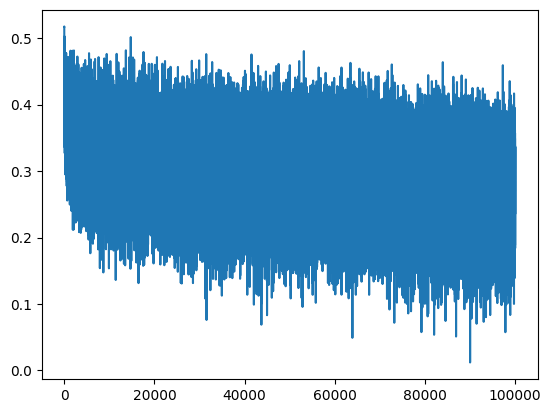

In [107]:
plt.plot(lossi)

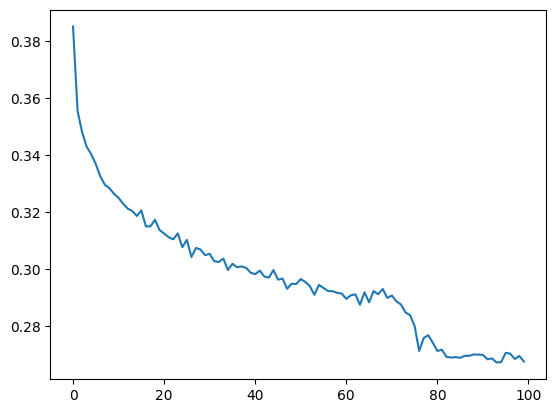

In [108]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [109]:
# putting layers into eval mode
for layer in model.layers:
  layer.training = False

In [110]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xtest, Ytest)
  }[split]

  logits = model(x)

  # emb = C[x]
  # x = emb.view(emb.shape[0], -1)
  # for layer in layers:
  #   x = layer(x)
  loss = F.cross_entropy(logits, y)   # loss function
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8388862609863281
val 1.987472653388977


In [111]:
# sample

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    # emb = C[torch.tensor([context])]
    # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    # logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()

    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mohamade.
lennah.
mariana.
salani.
miylea.
kafsen.
mangelizah.
kengeletso.
prisson.
asher.
eiko.
ramsad.
cambri.
kashley.
brylond.
hamir.
carler.
joosetouz.
nierzen.
arza.
